In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import matplotlib.patheffects as path_effects
from scipy.stats import skew, kurtosis
import svgutils.compose as sc

In [2]:
'''
20230112 - What is the expected return from auto-rolling a position every week?

Figure 1: Autoroll/rebuy/hold vs price
Figure 2: returns distribution + stats
Figure 3: 

'''

'\n20230112 - What is the expected return from auto-rolling a position every week?\n\nFigure 1: Autoroll vs price\nFigure 2: Compounding returns vs. width\nFigure 3: IL?  \n\n'

In [15]:
loadData=True
if loadData:
    # Load data from ETH-UNI-30bps pool
    ETHUNI30=pandas.read_gbq("SELECT DISTINCT * FROM `arcane-world-371019.First_sync.1` WHERE address='0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801' ORDER BY block_number, transaction_index  ", "arcane-world-371019")
    #ETHUNI30.to_csv('ETH-UNI-30bps.csv')
    loadData = False
    

In [16]:
ticks30 = []
sqrtPrice30 = []
block30 = []
timestamp30 = []
for index, row in ETHUNI30.iterrows():
    ticks30.append(row['tick'])
    sqrtPrice30.append((int(row['sqrtPrice'], 16)/2**96))
    block30.append(row['block_number'])
    timestamp30.append((row['block_timestamp']))
ticks30 = np.array(ticks30)
block30 = np.array(block30)
sqrtPrice30 = np.array(sqrtPrice30)

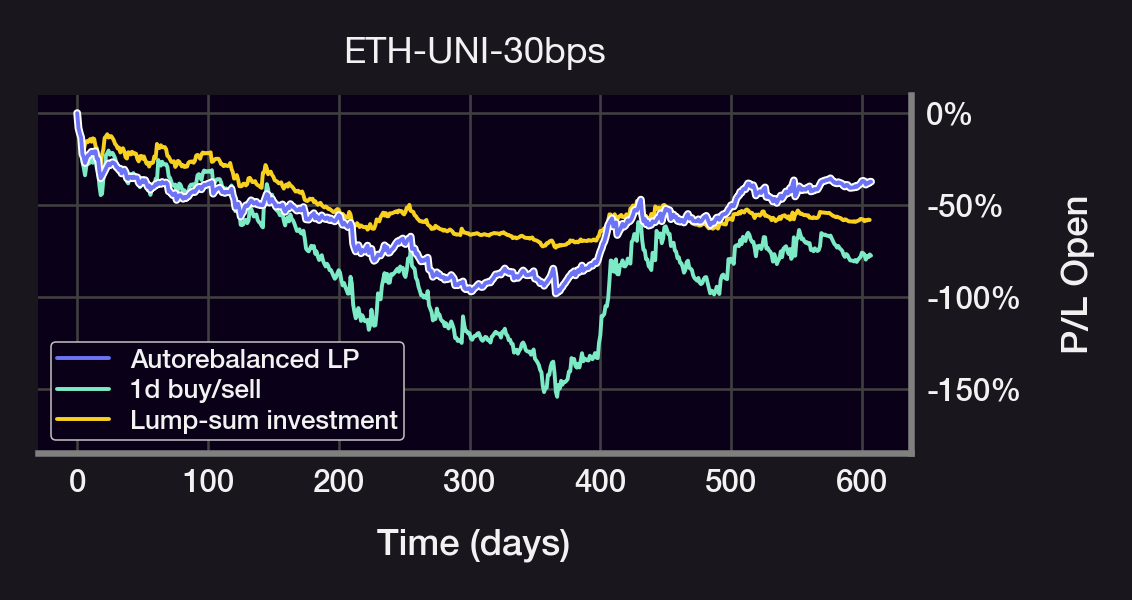

In [516]:
V = lambda x, k, r: (x<k/r)*x + (x>=k/r)*(x<=k*r)*(2*np.sqrt(x*k*r)-k-x)/(r-1) + (x>k*r)*k
X = lambda x, k, r, dL: (x<k/r)*dL*(1/np.sqrt(k/r) - 1/np.sqrt(k*r)) + (x>=k/r)*(x<=k*r)*dL*(1/np.sqrt(x) - 1/np.sqrt(k*r)) + (x>k*r)*0
Y = lambda x, k, r, dL: (x<k/r)*0 + (x>=k/r)*(x<=k*r)*dL*(np.sqrt(x) - np.sqrt(k/r)) + (x>k*r)*dL*(np.sqrt(k*r) - np.sqrt(k/r))                                                                                            
positionSize = 0.5*10**18
w = 360
r = 1.0001**w
nDays=1
df0 = []
df1 = []
strat = [0]
rebuy = [0]
hold = []
DCA = []
feesVal = []
rebalanceTick = []

for i, t in enumerate(timestamp30):
  
    if i == 0:
        startDay = t
        startTick = ticks30[i]
        startSqrtPrice = sqrtPrice30[i]
        startPrice = sqrtPrice30[i]**2
        startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        previousTick = ticks30[i]
        previoussqrtPrice = sqrtPrice30[i]
        
        positionRange = range(startTick - w, startTick + w)
    else:
       
        currentTick = ticks30[i]
        currentsqrtPrice = sqrtPrice30[i]
 
        if (currentTick in positionRange or
            previousTick in positionRange or
            (currentTick < positionRange[0] and previousTick > positionRange[-1]) or
            (currentTick > positionRange[-1] and previousTick < positionRange[0])):
          
            dT = currentsqrtPrice - previoussqrtPrice   
            if dT >= 0:
                pLow = np.max([previoussqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([currentsqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dy = startLiq * (pHigh - pLow)
                df1.append(dy*0.003)
            else:
                pLow = np.max([currentsqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([previoussqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dx = startLiq * (1/pLow-1/pHigh)
                df0.append(dx*0.003)    
  
        previousTick = ticks30[i]+0 
        previoussqrtPrice = sqrtPrice30[i]+0
    if (t-startDay).days>=nDays:

        rebalanceTick.append(i)
        
        endX = X(currentsqrtPrice**2, startPrice, r, startLiq)+sum(df0)
        endY = Y(currentsqrtPrice**2, startPrice, r, startLiq)+sum(df1)

        feesVal.append(sum(df1) + sum(df0) * currentsqrtPrice**2)
        df0 = []
        df1 = []
        
        strat.append((endX*currentsqrtPrice**2+endY - startX*startPrice - startY)/2/positionSize)
        rebuy.append((currentsqrtPrice**2/startPrice-1))
        hold.append(currentsqrtPrice**2/sqrtPrice30[0]**2)
        DCA.append(currentsqrtPrice**2)

        startDay = t
        startTick = ticks30[i]
        startSqrtPrice = sqrtPrice30[i]
        startPrice = sqrtPrice30[i]**2
        startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        positionRange = range(startTick - w, startTick + w)
        
        
plt.style.use('../../stylesheet/panoptic-dark-16_9.mplstyle')

plt.plot(np.cumsum(strat), lw=1.5, color='w', zorder=3)
plt.plot(np.cumsum(strat), label='Autorebalanced LP', zorder=3)
plt.plot(np.cumsum(rebuy), label='1d buy/sell')
#plt.plot(np.cumsum(DCA[-1]-DCA), label='DCA')
plt.plot((np.array(hold)-hold[0]), label='Lump-sum investment', color='#f8d120')

plt.yticks([0, -0.5, -1, -1.5, -2])
plt.gca().set_yticklabels([f'{(x):.0%}' for x in plt.gca().get_yticks()]) 
plt.ylim((-1.85, 0.1))

plt.title('ETH-UNI-30bps')

plt.xlabel('Time (days)')
plt.ylabel('P/L Open', labelpad=-203)
plt.legend()   

plt.savefig('ETH-Returns-1.svg')
plt.savefig('ETH-Returns-1.png', dpi=375)

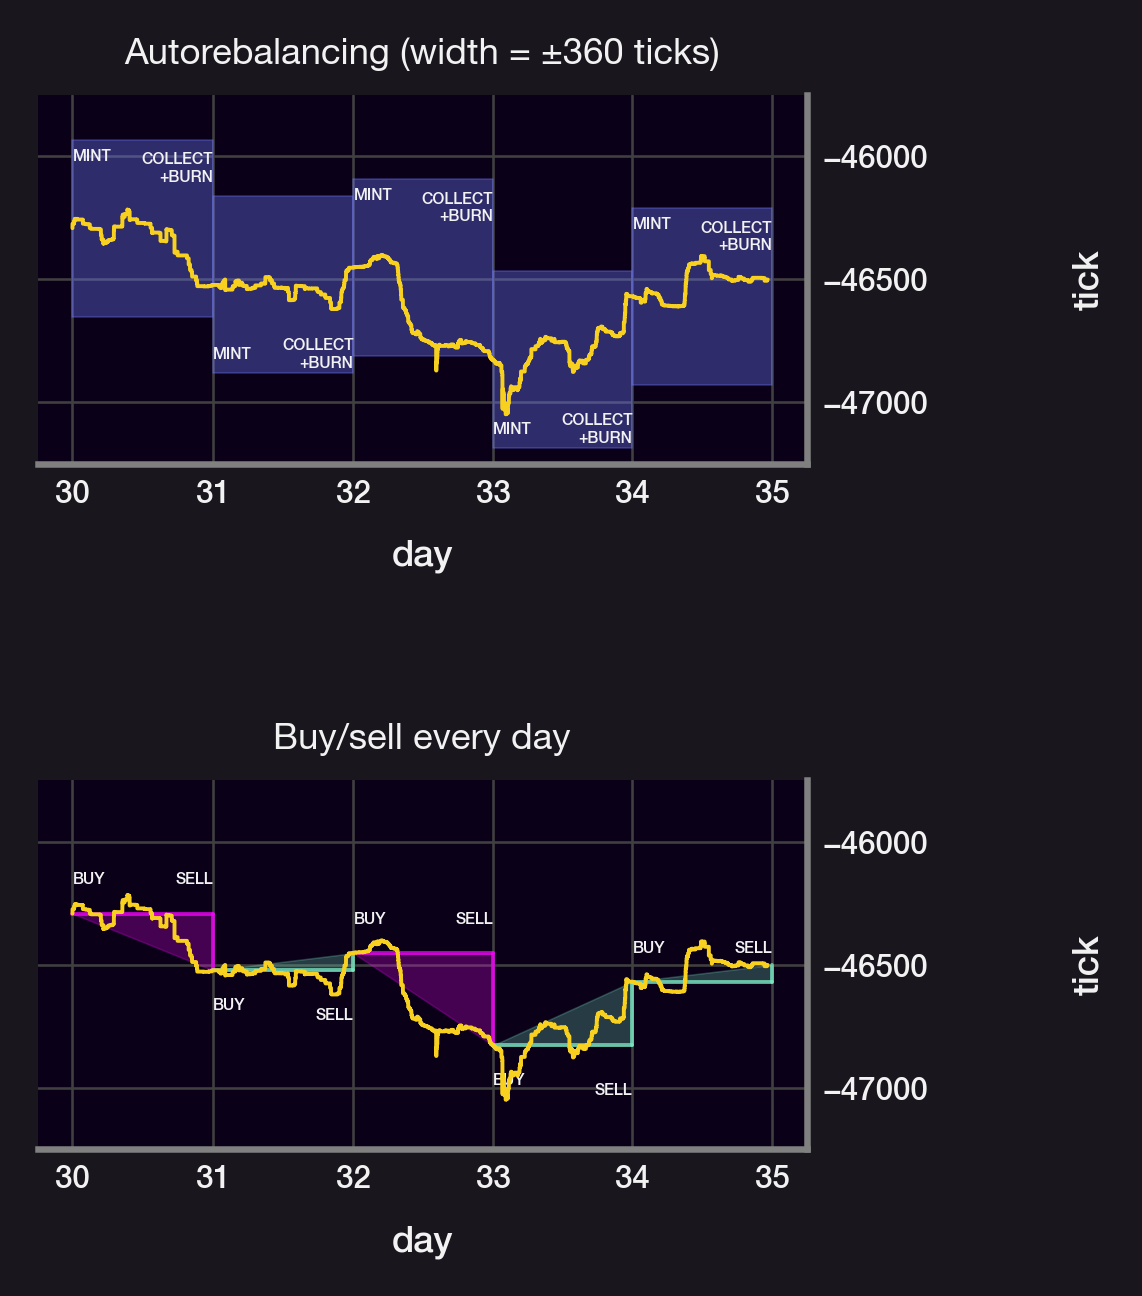

In [515]:
plt.style.use('../../stylesheet/panoptic-dark-7_8.mplstyle')
st = rebalanceTick[30]
en = rebalanceTick[35]
plt.subplot(2, 1,1)
plt.step(block30[st:en], ticks30[st:en], color='#f8d120', zorder=10)
plt.xticks(block30[rebalanceTick[30:36]],range(30,36)) 

for i in range(30, 35):
    plt.fill_between(block30[rebalanceTick[i:(i+2)]], 
                     [ticks30[rebalanceTick[i]]+360, ticks30[rebalanceTick[i]]+360], 
                     [ticks30[rebalanceTick[i]]-360, ticks30[rebalanceTick[i]]-360], 
                     color='#6c74f5', alpha=0.375)
    plt.text(block30[rebalanceTick[i]], ticks30[rebalanceTick[i]]+275 - (i%2)*575, 'MINT', ha='left', fontsize=3)
    plt.text(block30[rebalanceTick[i+1]], ticks30[rebalanceTick[i]]+190 - (i%2)*525, 'COLLECT\n+BURN', ha='right', fontsize=3)
plt.xlabel('day')
plt.ylabel('tick', labelpad=-205)
plt.title('Autorebalancing (width = ±360 ticks)')
plt.ylim((-47250, -45750))
plt.subplot(2, 1,2)

plt.xticks(block30[rebalanceTick[30:36]],range(30,36)) 

for i in range(30, 35):
    if ticks30[rebalanceTick[i]] > ticks30[rebalanceTick[i+1]]:
        c='#f305f9'
    else:
        c='#7ceac5'
    plt.plot(block30[rebalanceTick[i:(i+2)]], 
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]], 
                     color=c, alpha=0.75)
    plt.plot([block30[rebalanceTick[(i+1)]],block30[rebalanceTick[(i+1)]]], 
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i+1]]], 
                     color=c, alpha=0.75)    
    plt.fill_between(block30[rebalanceTick[i:(i+2)]], 
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i+1]]],
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]],
                     color=c, alpha=0.25)
    plt.text(block30[rebalanceTick[i]], ticks30[rebalanceTick[i]]+120 - (i%2)*280, 'BUY', ha='left', fontsize=3)
    plt.text(block30[rebalanceTick[i+1]], ticks30[rebalanceTick[i]]+120 - (i%2)*320, 'SELL', ha='right', fontsize=3)
plt.step(block30[st:en], ticks30[st:en], color='#f8d120', zorder=10)
plt.xlabel('day')
plt.ylabel('tick', labelpad=-205)
plt.title('Buy/sell every day')
plt.ylim((-47250, -45750))
plt.savefig('ETH-Dist-1.svg')
plt.savefig('ETH-Dist-1.png', dpi=375)
           
           

/var/folders/n4/dw74sg2n5s9crdkbbv0m1hh80000gn/T/ipykernel_36473/2359352650.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()])
/var/folders/n4/dw74sg2n5s9crdkbbv0m1hh80000gn/T/ipykernel_36473/2359352650.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()])


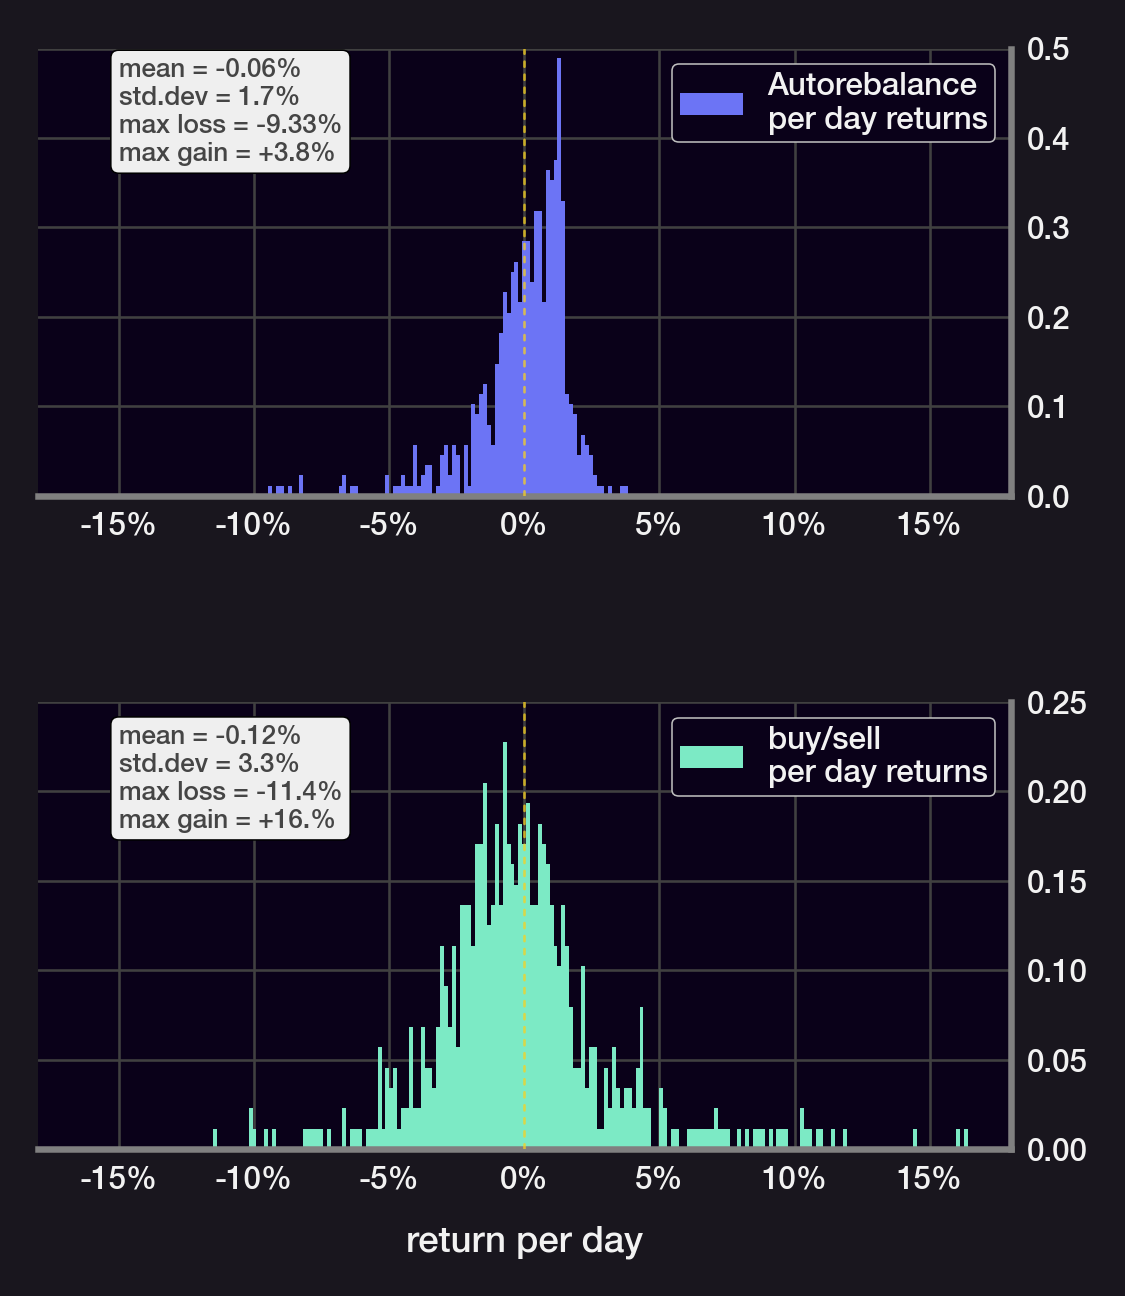

In [503]:
plt.style.use('../../stylesheet/panoptic-dark-7_8.mplstyle')
plt.subplot(2, 1,1)
plt.plot([0, 0],[0, 0.5], lw=0.5, color='#f8d120', dashes=(2, 3), zorder=4, alpha=0.75) 
plt.hist(np.array(strat)*100, np.linspace(-18, 18, 250), density=True, label='Autorebalance\nper day returns')
#plt.hist(np.array(feesVal)/0.5/10**18, np.linspace(-0.3, 0.3, 100), density=True, histtype='step')
plt.legend()
plt.text(-15, 0.375, 'mean = '+str(np.mean(strat)*100)[:5]+'%\nstd.dev = '+str(np.std(strat)*100)[:3]+'%\nmax loss = '+str(min(strat)*100)[:5]+'%\nmax gain = +'+str(max(strat)*100)[:3]+'%', color='#454545', fontsize=5, bbox=dict(boxstyle='round', fc="#efefef", ec="k"))
plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()]) 
plt.xlim((-18, 18))
plt.ylim((0, 0.5))
plt.subplot(2, 1,2)
plt.plot([0, 0],[0, 0.5], lw=0.5, color='#f8d120', dashes=(2, 3), zorder=4, alpha=0.75) 
plt.hist([-100, -100])
plt.hist(np.array(rebuy)*100, np.linspace(-18, 18, 250), density=True, label='buy/sell\nper day returns')
plt.text(-15, 0.18, 'mean = '+str(np.mean(rebuy)*100)[:5]+'%\nstd.dev = '+str(np.std(rebuy)*100)[:3]+'%\nmax loss = '+str(min(rebuy)*100)[:5]+'%\nmax gain = +'+str(max(rebuy)*100)[:3]+'%', color='#454545', fontsize=5, bbox=dict(boxstyle='round', fc="#efefef", ec="k"))
plt.legend()
plt.xlim((-18, 18))
plt.ylim((0, 0.25))
plt.xlabel('return per day')
plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()]) 

plt.savefig('ETH-Dist-2.svg')
plt.savefig('ETH-Dist-2.png', dpi=375)

(array([11., 43., 40., 61., 58., 55., 44., 38., 40., 24., 27., 18., 19.,
        23., 14., 16.,  5.,  6.,  6.,  8.,  2.,  4.,  4.,  5.,  4.,  4.,
         3.,  5.,  3.,  1.,  0.,  1.,  1.,  2.,  2.,  0.,  0.,  0.,  2.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([8.00648865e+14, 1.37419476e+15, 1.94774066e+15, 2.52128655e+15,
        3.09483245e+15, 3.66837835e+15, 4.24192424e+15, 4.81547014e+15,
        5.38901603e+15, 5.96256193e+15, 6.53610783e+15, 7.10965372e+15,
        7.68319962e+15, 8.25674552e+15, 8.83029141e+15, 9.40383731e+15,
        9.97738320e+15, 1.05509291e+16, 1.11244750e+16, 1.16980209e+16,
        1.22715668e+16, 1.28451127e+16, 1.34186586e+16, 1.39922045e+16,
  

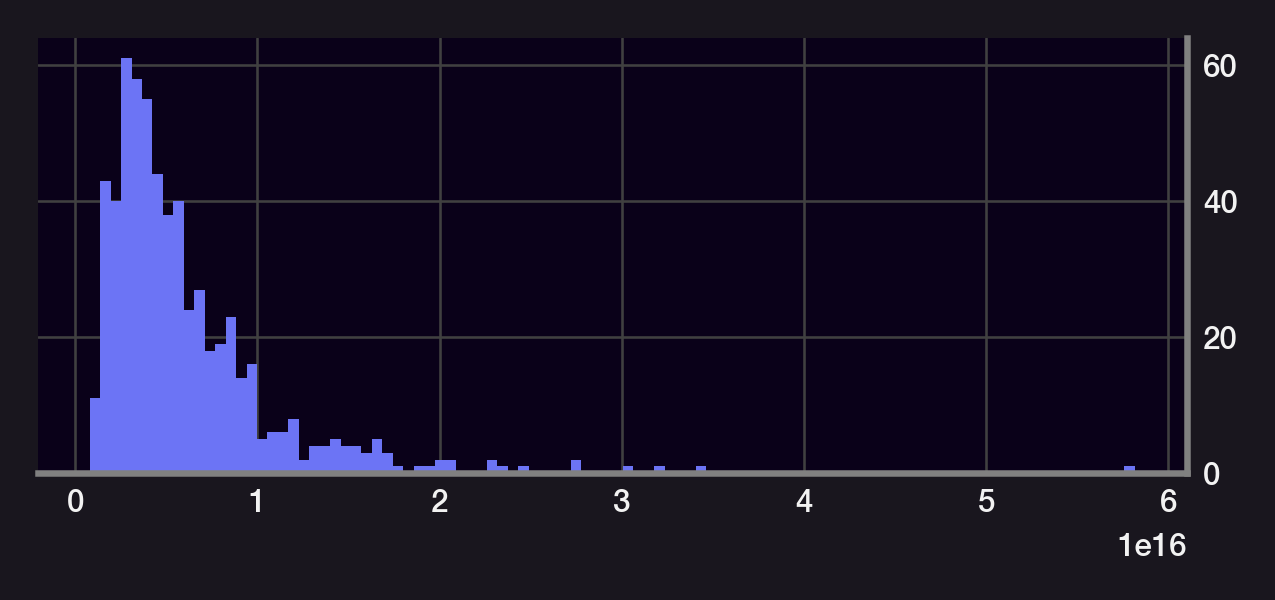

(array([11., 43., 40., 61., 58., 55., 44., 38., 40., 24., 27., 18., 19.,
        23., 14., 16.,  5.,  6.,  6.,  8.,  2.,  4.,  4.,  5.,  4.,  4.,
         3.,  5.,  3.,  1.,  0.,  1.,  1.,  2.,  2.,  0.,  0.,  0.,  2.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([8.00648865e+14, 1.37419476e+15, 1.94774066e+15, 2.52128655e+15,
        3.09483245e+15, 3.66837835e+15, 4.24192424e+15, 4.81547014e+15,
        5.38901603e+15, 5.96256193e+15, 6.53610783e+15, 7.10965372e+15,
        7.68319962e+15, 8.25674552e+15, 8.83029141e+15, 9.40383731e+15,
        9.97738320e+15, 1.05509291e+16, 1.11244750e+16, 1.16980209e+16,
        1.22715668e+16, 1.28451127e+16, 1.34186586e+16, 1.39922045e+16,
  

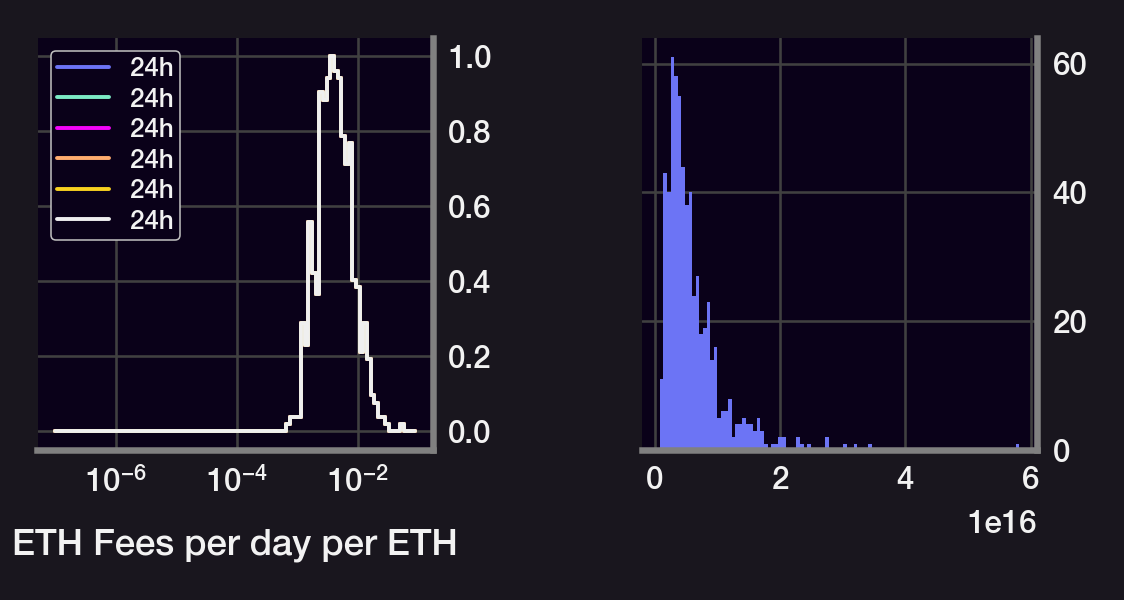

In [513]:
plt.style.use('../../stylesheet/panoptic-dark-16_9.mplstyle')
plt.subplot(1,2,1)
V = lambda x, k, r: (x<k/r)*x + (x>=k/r)*(x<=k*r)*(2*np.sqrt(x*k*r)-k-x)/(r-1) + (x>k*r)*k
X = lambda x, k, r, dL: (x<k/r)*dL*(1/np.sqrt(k/r) - 1/np.sqrt(k*r)) + (x>=k/r)*(x<=k*r)*dL*(1/np.sqrt(x) - 1/np.sqrt(k*r)) + (x>k*r)*0
Y = lambda x, k, r, dL: (x<k/r)*0 + (x>=k/r)*(x<=k*r)*dL*(np.sqrt(x) - np.sqrt(k/r)) + (x>k*r)*dL*(np.sqrt(k*r) - np.sqrt(k/r))                                                                                            
positionSize = 0.5*10**18


for j, nSecs in enumerate([60, 120, 240, 480, 960, 1920]):
    #w = 360
    #nDays = 1
    nSecs = 24*3600
    r = 1.0001**w
    
    df0 = []
    df1 = []
    strat = [0]
    rebuy = [0]
    hold = []    
    b = [block30[0]]
    feesVal = []
    for i, t in enumerate(timestamp30):

        if i == 0:
            startDay = t
            startTick = ticks30[i]
            startSqrtPrice = sqrtPrice30[i]
            startPrice = sqrtPrice30[i]**2
            startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
            startX = X(startPrice, startPrice, r, startLiq)
            startY = Y(startPrice, startPrice, r, startLiq)
            previousTick = ticks30[i]
            previoussqrtPrice = sqrtPrice30[i]
            positionRange = range(startTick - w, startTick + w)            
        else:

            currentTick = ticks30[i]
            currentsqrtPrice = sqrtPrice30[i]

            if (currentTick in positionRange or
                previousTick in positionRange or
                (currentTick < positionRange[0] and previousTick > positionRange[-1]) or
                (currentTick > positionRange[-1] and previousTick < positionRange[0])):

                dT = currentsqrtPrice - previoussqrtPrice  
                if dT >= 0:
                    pLow = np.max([previoussqrtPrice, np.sqrt(1.0001**(startTick-w))])
                    pHigh = np.min([currentsqrtPrice, np.sqrt(1.0001**(startTick+w))])
                    dy = startLiq * (pHigh - pLow)
                    df1.append(dy*0.003)
                else:
                    pLow = np.max([currentsqrtPrice, np.sqrt(1.0001**(startTick-w))])
                    pHigh = np.min([previoussqrtPrice, np.sqrt(1.0001**(startTick+w))])
                    dx = startLiq * (1/pLow-1/pHigh)
                    df0.append(dx*0.003)  
            previousTick = ticks30[i]+0 
            previoussqrtPrice = sqrtPrice30[i]+0
        if (t-startDay).total_seconds()>=nSecs:

            endX = X(currentsqrtPrice**2, startPrice, r, startLiq)+sum(df0)
            endY = Y(currentsqrtPrice**2, startPrice, r, startLiq)+sum(df1)

            feesVal.append(sum(df1) + sum(df0) * currentsqrtPrice**2)
            
            df0 = []
            df1 = []

            strat.append((endX*currentsqrtPrice**2+endY - startX*startPrice - startY)/positionSize)
            rebuy.append(2*(currentsqrtPrice**2/startPrice-1))
            hold.append(2*currentsqrtPrice**2/sqrtPrice30[0]**2)
            b.append(block30[i])

            startDay = t
            startTick = ticks30[i]
            startSqrtPrice = sqrtPrice30[i]
            startPrice = sqrtPrice30[i]**2
            startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
            startX = X(startPrice, startPrice, r, startLiq)
            startY = Y(startPrice, startPrice, r, startLiq)
            positionRange = range(startTick - w, startTick + w)  


    [a, b] = np.histogram(np.array(feesVal)/10**18, np.logspace(-7, -1, 100))
    plt.step(b[:-1], a/max(a)+1.125*0, label=str(int(nSecs/3600))[:4]+'h')

    #plt.plot(nSecs, np.mean(feesVal), 'o', mfc='#6c74f5', mec='#efefef')
    #plt.plot((np.array(hold)-hold[0])/10**18, label='Buy UNI')
#plt.ylabel('return/day')
plt.legend()    
plt.semilogx()
plt.xlabel('ETH Fees per day per ETH')
#plt.yticks([0, -0.5, -1, -1.5, -2])
#plt.gca().set_yticklabels([f'{(x):.0%}' for x in plt.gca().get_yticks()]) 
#plt.ylim((-2.25, 0.1))

plt.subplot(1,2,2)

plt.hist(feesVal, 100)
#plt.title('ETH-UNI-30bps: Rebalancing frequency (width=3.6%)')
#plt.xlabel('blockNumber')
#plt.plot(b, np.cumsum(rebuy), color='#cc333f', label='Rebalance UNI')   
#plt.tight_layout()
#plt.savefig('ETH-Params-1.svg')
#plt.savefig('ETH-Params-1.png', dpi=375)

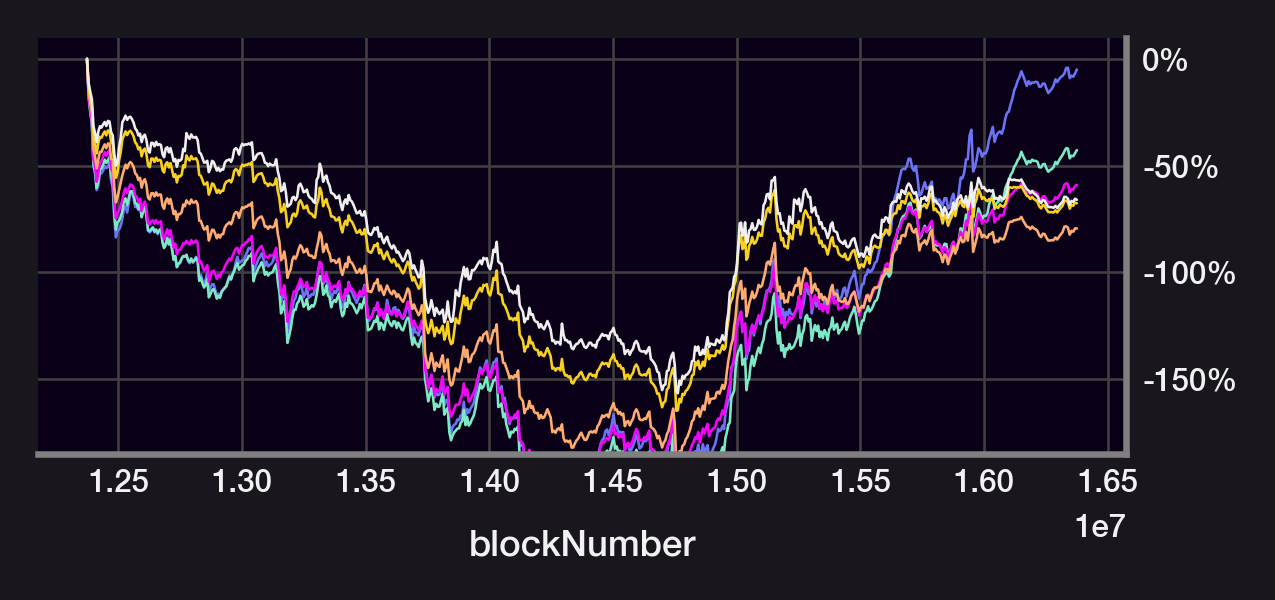

In [477]:
plt.style.use('../../stylesheet/panoptic-dark-2_1.mplstyle')
V = lambda x, k, r: (x<k/r)*x + (x>=k/r)*(x<=k*r)*(2*np.sqrt(x*k*r)-k-x)/(r-1) + (x>k*r)*k
X = lambda x, k, r, dL: (x<k/r)*dL*(1/np.sqrt(k/r) - 1/np.sqrt(k*r)) + (x>=k/r)*(x<=k*r)*dL*(1/np.sqrt(x) - 1/np.sqrt(k*r)) + (x>k*r)*0
Y = lambda x, k, r, dL: (x<k/r)*0 + (x>=k/r)*(x<=k*r)*dL*(np.sqrt(x) - np.sqrt(k/r)) + (x>k*r)*dL*(np.sqrt(k*r) - np.sqrt(k/r))                                                                                            
positionSize = 0.5*10**18


for w in [60, 120, 240, 480, 960, 1920]:
    nSecs = 24*3600
    r = 1.0001**w
    
    df0 = []
    df1 = []
    strat = [0]
    rebuy = [0]
    hold = []    
    b = [block30[0]]
    for i, t in enumerate(timestamp30):

        if i == 0:
            startDay = t
            startTick = ticks30[i]
            startSqrtPrice = sqrtPrice30[i]
            startPrice = sqrtPrice30[i]**2
            startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
            startX = X(startPrice, startPrice, r, startLiq)
            startY = Y(startPrice, startPrice, r, startLiq)
            previousTick = ticks30[i]
            previoussqrtPrice = sqrtPrice30[i]
            positionRange = range(startTick - w, startTick + w)            
        else:

            currentTick = ticks30[i]
            currentsqrtPrice = sqrtPrice30[i]

            if (currentTick in positionRange or
                previousTick in positionRange or
                (currentTick < positionRange[0] and previousTick > positionRange[-1]) or
                (currentTick > positionRange[-1] and previousTick < positionRange[0])):

                dT = currentsqrtPrice - previoussqrtPrice  
                if dT >= 0:
                    pLow = np.max([previoussqrtPrice, np.sqrt(1.0001**(startTick-w))])
                    pHigh = np.min([currentsqrtPrice, np.sqrt(1.0001**(startTick+w))])
                    dy = startLiq * (pHigh - pLow)
                    df1.append(dy*0.003)
                else:
                    pLow = np.max([currentsqrtPrice, np.sqrt(1.0001**(startTick-w))])
                    pHigh = np.min([previoussqrtPrice, np.sqrt(1.0001**(startTick+w))])
                    dx = startLiq * (1/pLow-1/pHigh)
                    df0.append(dx*0.003)  
            previousTick = ticks30[i]+0 
            previoussqrtPrice = sqrtPrice30[i]+0
        if (t-startDay).total_seconds()>=nSecs:

            endX = X(currentsqrtPrice**2, startPrice, r, startLiq)+sum(df0)
            endY = Y(currentsqrtPrice**2, startPrice, r, startLiq)+sum(df1)
            df0 = []
            df1 = []

            strat.append((endX*currentsqrtPrice**2+endY - startX*startPrice - startY)/positionSize)
            rebuy.append(2*(currentsqrtPrice**2/startPrice-1))
            hold.append(2*currentsqrtPrice**2/sqrtPrice30[0]**2)
            b.append(block30[i])

            startDay = t
            startTick = ticks30[i]
            startSqrtPrice = sqrtPrice30[i]
            startPrice = sqrtPrice30[i]**2
            startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
            startX = X(startPrice, startPrice, r, startLiq)
            startY = Y(startPrice, startPrice, r, startLiq)
            positionRange = range(startTick - w, startTick + w)  




    plt.plot(b, np.cumsum(strat), label=str(int((r-1)*1000)/10)[:4]+'%')

    #plt.plot((np.array(hold)-hold[0])/10**18, label='Buy UNI')

plt.legend()   
plt.yticks([0, -0.5, -1, -1.5, -2])
plt.gca().set_yticklabels([f'{(x):.0%}' for x in plt.gca().get_yticks()]) 
plt.ylim((-2.25, 0.1))

plt.xlabel('blockNumber')
#plt.ylabel('P/L Open', labelpad=0)

plt.tight_layout()
plt.savefig('ETH-Params-2.svg')
plt.savefig('ETH-Params-2.png', dpi=375)

In [492]:
np.log(np.array(feesVal)/10**18)

array([-6.09413039, -6.31481899, -6.31665471, -6.20604529, -5.30138237,
       -5.86224331, -4.5548506 , -4.30233929, -5.16447742, -5.16685842,
       -5.53274772, -5.79870468, -6.05233944, -5.70634258, -6.28406413,
       -4.73647608, -6.25895665, -5.451064  , -4.79753638, -5.48086156,
       -5.1515198 , -5.34344083, -4.50439082, -5.05475193, -5.34774811,
       -5.06756983, -5.17878142, -5.35880691, -5.77369807, -6.09125413,
       -6.18544566, -5.7752789 , -5.84421175, -5.79233614, -5.02446334,
       -5.99072633, -5.81464217, -5.62019165, -6.32102581, -6.35766763,
       -6.49053294, -6.34810759, -6.50921855, -6.53780952, -6.51831262,
       -6.13031606, -5.76317811, -5.30039904, -5.21088956, -5.01958728,
       -5.70896244, -5.51448865, -6.3534562 , -5.70229843, -5.50489111,
       -5.79910135, -5.55116758, -6.36034674, -6.14501199, -5.62431325,
       -5.60813988, -6.42961694, -4.64369239, -5.83492645, -5.78498932,
       -6.61597305, -6.8334276 , -5.85946701, -6.07386359, -6.32

In [518]:
print(np.sum(strat))

print(np.sum(rebuy))
#plt.plot(np.cumsum(DCA[-1]-DCA), label='DCA')
(np.array(hold)-hold[0])[-1]

-0.3731614456894712
-0.7755093175554201


-0.58120851959898